## Предсказание будущих продаж

        В этой задаче необходимо работать со сложным набором данных временных рядов, состоящим из ежедневных данных о продажах, любезно предоставленных одной из крупнейших российских компаний-разработчиков программного обеспечения - компанией 1С . 
        Необходимо спрогнозировать общий объем продаж для каждого продукта и магазина в следующем месяце.

In [1]:
# установим дополнительную библиотеку с информацией о праздничных днях
!pip install holidays

In [2]:
# подключим неободимые библиотеки
import pandas as pd
import numpy as np

from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error as mae, mean_squared_error as mse
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FormatStrFormatter, NullLocator
import seaborn as sns

import calendar
import holidays
from tqdm import tqdm
from collections import Counter

from torch import nn
import torch
from torch.utils.data import Dataset, DataLoader

from IPython.display import clear_output


%matplotlib inline

In [3]:
## Загружаем все датасеты
df_sales = pd.read_csv('../input/competitive-data-science-predict-future-sales/sales_train.csv')
df_items = pd.read_csv('../input/competitive-data-science-predict-future-sales/items.csv')
df_shops = pd.read_csv('../input/competitive-data-science-predict-future-sales/shops.csv')
df_categories = pd.read_csv('../input/competitive-data-science-predict-future-sales/item_categories.csv')
df_test_sales = pd.read_csv('../input/competitive-data-science-predict-future-sales/test.csv')
df_sample = pd.read_csv('../input/competitive-data-science-predict-future-sales/sample_submission.csv')

## 1. Предобработка данных
- Фильтрация данных
- Групировка данных

In [4]:
## Реализуем следующие функции:
## drop_wrong_rows - фильтруем исхоный датасет с продажами от наличия неправильных значений
## generate_holidays_weekends - сгенерируем признаки был ли день продажи праздничным или выходным
## generate_month_year - сгенерируем признаки месяца и года
def drop_wrong_rows(dataframe):
    df = dataframe.copy()
    df = df[df.item_price > 0]
    df = df[df.item_cnt_day > 0]
    df = df.drop_duplicates()
    return df

def generate_holidays_weekends(dataframe):
    df = dataframe.copy()
    df['date'] = pd.to_datetime(df.date, format='%d.%m.%Y')
    df['weekday'] = df.date.apply(lambda x: calendar.weekday(x.year, x.month, x.day))
    df['Is_holiday'] = df.date.isin(list(holidays.Russia(years = [2013, 2014, 2015]).keys())) * 1  
    df['is_weekend'] = df.weekday.apply(lambda x: int(x >= 5))
    return df

def generate_month_year(dataframe):
    df = dataframe.copy()
    df['month'] = df.date.apply(lambda x: x.month)
    df['year'] = df.date.apply(lambda x: x.year)
    return df

In [5]:
%%time
## Проведем первичные преобразования
df_sales = drop_wrong_rows(df_sales)
data = generate_holidays_weekends(df_sales)
data = generate_month_year(data)
data.head()

CPU times: user 1min 2s, sys: 1.85 s, total: 1min 3s
Wall time: 1min 3s


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,weekday,Is_holiday,is_weekend,month,year
0,2013-01-02,0,59,22154,999.00,1.0,2,1,0,1,2013
1,2013-01-03,0,25,2552,899.00,1.0,3,1,0,1,2013
3,2013-01-06,0,25,2554,1709.05,1.0,6,1,1,1,2013
4,2013-01-15,0,25,2555,1099.00,1.0,1,0,0,1,2013
5,2013-01-10,0,25,2564,349.00,1.0,3,0,0,1,2013


In [6]:
## Создадим класс для групировки всех датасетов
class TransformMergeData:
    
    def __init__(self, data):
        self.data = data.copy()

    @property
    def group_sales_by_date_blocks(self):  ## атрибут для групировки продаж по месяцу, магазину и товару
        new_data = self.data.copy()
        new_data['min_date'] = new_data['date']
        new_data['max_date'] = new_data['date']
        new_data = new_data.groupby(['date_block_num', 'shop_id', 'item_id'], as_index=False).agg({'item_cnt_day': 'sum', 'month': 'mean',
                                                                                'year': 'mean', 'is_weekend': 'sum',
                                                                                'Is_holiday': 'sum', 'date': 'count',
                                                                                'min_date': 'min', 'max_date': 'max', 'item_price': 'mean'}).reset_index(drop=True)
        
        new_data.drop_duplicates()

        
        new_data['holidays_count'] = new_data['is_weekend'] + new_data['Is_holiday']
        new_data = new_data.rename(columns={'date': 'days_count'})
        new_data.drop(columns = ['is_weekend', 'Is_holiday'], inplace=True)
        self.new_data = new_data
        return new_data

    
    def merge_all(self, df_shops, df_items, df_categories): ## метод объединющий все датасеты
        return pd.merge(pd.merge(pd.merge(self.new_data, df_shops, on='shop_id'), df_items, on='item_id'), df_categories, on='item_category_id')
    

In [7]:
## Сформируем новый датасет на основе предыдущих, который будет хранить информацию о продажах каждого товара по месяцам, а не по дням.
transformer = TransformMergeData(data)
data = transformer.group_sales_by_date_blocks.head()
data = transformer.merge_all(df_shops, df_items, df_categories)
data = drop_wrong_rows(data)
data.head()

,date_block_num,shop_id,item_id,item_cnt_day,month,year,days_count,min_date,max_date,item_price,holidays_count,shop_name,item_name,item_category_id,item_category_name
0,0,0,32,6.0,1,2013,4,2013-01-03,2013-01-31,221.0,1,"!Якутск Орджоникидзе, 56 фран",1+1,40,Кино - DVD
1,1,0,32,10.0,2,2013,7,2013-02-05,2013-02-25,221.0,1,"!Якутск Орджоникидзе, 56 фран",1+1,40,Кино - DVD
2,0,1,32,7.0,1,2013,6,2013-01-05,2013-01-22,221.0,5,"!Якутск ТЦ ""Центральный"" фран",1+1,40,Кино - DVD
3,1,1,32,3.0,2,2013,3,2013-02-04,2013-02-24,221.0,2,"!Якутск ТЦ ""Центральный"" фран",1+1,40,Кино - DVD
4,12,2,32,1.0,1,2014,1,2014-01-13,2014-01-13,119.0,0,"Адыгея ТЦ ""Мега""",1+1,40,Кино - DVD


## 2. Визуализация данных

In [8]:
## Создадим класс для визуализации данных
class Plotter:
    """ Класс для визуализации признаков и их зависимостей"""
    
    def __init__(self, dataframe):
        self.data = dataframe.copy()
        self.data['revenue'] = self.data['item_cnt_day'] * self.data['item_price']

    ## Атрибут для отображения выручки и объема продаж за весь преиод с разбивкой по месяцам
    @property
    def plot_month_realation(self):
        
        fig, axes = plt.subplots(2,1, figsize=(22,13))
        fig.suptitle('Динамика выручки и объема продаж по месяцам', fontsize=20)
        ax1, ax2 = axes[0], axes[1]
        
        ax1.set_title('Динамика выручки', fontsize=16)     
        self.data.groupby('date_block_num')['revenue'].sum().plot(ax=ax1, label='Revenue')
        plt.setp(ax1.lines, linewidth=5, linestyle='--', marker='o', 
                markersize=12, markerfacecolor='skyblue', alpha=0.5, color='blue')
        ax1.set_xlabel('Месяц', fontsize=13, alpha=0.7)
        ax1.set_ylabel('Выручка', fontsize=13, alpha=0.7)   
        ax1.legend(loc='best')
        ax1.grid()
        
        ax2.set_title('Динамика объема продаж', fontsize=16)     
        self.data.groupby('date_block_num')['item_cnt_day'].sum().plot(ax=ax2, label='Item_cnt_month')
        plt.setp(ax2.lines, linewidth=5, linestyle='--', marker='o', 
                markersize=12, markerfacecolor='skyblue', color='lightgreen', alpha=0.9)
        ax2.set_xlabel('Месяц', fontsize=13, alpha=0.9)
        ax2.set_ylabel('Объем продаж', fontsize=13, alpha=0.7)   
        ax2.legend(loc='best')
        ax2.grid()      
        
        plt.show()

    ## Атрибут для отображения самых популярных магазинов, категорий товаров и самих номенклатур в зависимости от объемов продаж
    @property
    def plot_shop_category_relation(self):
                
        fig, axes = plt.subplots(1,2, figsize=(22,13))
        fig.suptitle('Зависимость объема продаж от категории товара и от магазина', fontsize=20)
        ax1, ax2 = axes[0], axes[1]
        
        values = self.data.groupby('item_category_name')['item_cnt_day'].sum().values
        labels = self.data.groupby('item_category_name')['item_cnt_day'].sum().index
        labels = [' '.join(label.split(' ')[:3]) for label in labels]
        labels = [labels[i] for i in range(len(labels)) if values[i]/sum(values) > 0.05]
        values_1 = [values[i] for i in range(len(values)) if values[i]/sum(values) > 0.05]
        values_2 = sum([values[i] for i in range(len(values)) if values[i]/sum(values) < 0.05])
        values = values_1 + [values_2]
        labels = labels + ['Другие']
        
        ax1.set_title('Продажи по категориям товаров', fontsize=16) 
        ax1.pie(values, autopct='%.2f', textprops={'fontsize': 13}, 
                colors=['aquamarine', 'azure', 'gold', 'lightgreen', 'silver', 'wheat', 'orchid'], 
                shadow=True, wedgeprops = {'width': 0.9}, explode=[0,0,0,0.1,0,0,0])
        ax1.legend(labels, loc='upper left', fontsize=9)
        
        
        values = self.data.groupby('item_name')['item_cnt_day'].sum().values
        labels = self.data.groupby('item_name')['item_cnt_day'].sum().index
        labels = [' '.join(label.split(' ')[:3]) for label in labels]
        s = sum(values)
        labels = [labels[i] for i in range(len(labels)) if values[i]/s > 0.003]
        values = [values[i] for i in range(len(values)) if values[i]/s > 0.003]
        values_1 = [values[i] for i in range(len(values)) if values[i]/sum(values) > 0.003]
        values_2 = sum([values[i] for i in range(len(values)) if values[i]/sum(values) < 0.003])
        values = values_1 + [values_2]
        labels = labels + ['Другие']
        
        ax2.set_title('Продажи по номенклатуре товаров', fontsize=16) 
        ax2.pie(values, autopct='%.2f', textprops={'fontsize': 13}, 
                colors=['aquamarine', 'azure', 'gold', 'lightgreen', 'silver', 'wheat', 'orchid'], 
                shadow=True, wedgeprops = {'width': 0.9}, explode=[0,0,0,0,0,0.1,0])
        ax2.legend(labels, loc='upper right', fontsize=8)
        
        sns.catplot(x = 'shop_id', data=data, kind ='count', height=8, aspect=19/8);
        plt.title('Объем продаж в зависимости от магазина', fontsize=16)
        plt.xlabel('Индикатор магазина', fontsize=13)
        plt.ylabel('Объем продаж', fontsize=13)

    
    ## Атрибут для отображения распределения признака цены товара и целевой переменной - объема продаж
    @property
    def plot_numeric_features_distribution(self):
        fig = plt.figure(figsize=(23,15))
        fig.suptitle('Распределения объемов продаж и цен на товары', fontsize=20)
        fig.set_facecolor('lightgray')
        gs = GridSpec(ncols=3, nrows=2, figure=fig)
                    
        ax1 = fig.add_subplot(gs[0,0])
        sns.kdeplot(data=self.data, x='item_price', ax=ax1, label='Цена');
        ax1.set_title('Распределение цен на товары', fontsize=14)
        plt.setp(ax1.lines, linewidth=2, linestyle='--', color='blue', alpha=0.5)
        ax1.set_xlabel('Price', fontsize=11, alpha=0.7)
        ax1.set_ylabel('Density', fontsize=11, alpha=0.7)
        ax1.grid(alpha=0.8)
        ax1.legend(loc='best', fontsize=11)
        
        ax2 = fig.add_subplot(gs[0,1])
        df1 = pd.DataFrame({'item_price': data['item_price']})
        df1['item_price'] = df1['item_price'].apply(lambda x: np.log(x))
        sns.kdeplot(data=df1, x='item_price', ax=ax2, label='Цена');
        ax2.set_title('Логарифм цен на товары - 1', fontsize=14)
        plt.setp(ax2.lines, linewidth=3, linestyle='--', color='blue', alpha=0.5)
        ax2.set_xlabel('Price', fontsize=11, alpha=0.7)
        ax2.set_ylabel('Density', fontsize=11, alpha=0.7)
        ax2.grid(alpha=0.8)
        ax2.legend(loc='best', fontsize=11)
        
        ax3 = fig.add_subplot(gs[1,0])
        sns.kdeplot(data=self.data, x='item_cnt_day', ax=ax3, label='Объем продаж');
        ax3.set_title('Распределение объема продаж', fontsize=14)
        plt.setp(ax3.lines, linewidth=2, linestyle='--', color='green', alpha=0.8)
        ax3.set_xlabel('Item Count', fontsize=11, alpha=0.7)
        ax3.set_ylabel('Density', fontsize=11, alpha=0.7)
        ax3.grid(alpha=0.8)
        ax3.legend(loc='best', fontsize=11)
        
        ax4 = fig.add_subplot(gs[1,1])
        df2 = pd.DataFrame({'item_cnt_day': data['item_cnt_day']})
        df2['item_cnt_day'] = df2['item_cnt_day'].apply(lambda x: np.log(x))
        sns.kdeplot(data=df2, x='item_cnt_day', ax=ax4, label='Объем продаж');
        ax4.set_title('Логарифм объема продаж - 1', fontsize=14)
        plt.setp(ax4.lines, linewidth=3, linestyle='--', color='green', alpha=0.5)
        ax4.set_xlabel('Item Count', fontsize=11, alpha=0.7)
        ax4.set_ylabel('Density', fontsize=11, alpha=0.7)
        ax4.grid(alpha=0.8)
        ax4.legend(loc='best', fontsize=11)
        
        
        ax5 = fig.add_subplot(gs[0,2])
        sns.violinplot(x=df1['item_price'], ax=ax5, color='skyblue', alpha=0.8, label='Цена')
        ax5.set_title('Логарифм цен на товары - 2', fontsize=14)
        ax5.set_xlabel('Price', fontsize=11, alpha=0.7)
        ax5.grid(alpha=0.3)
        
        
        ax6 = fig.add_subplot(gs[1,2])
        sns.violinplot(x=df2['item_cnt_day'], ax=ax6, color='lightgreen', alpha=0.8, label='Объем продаж')
        ax6.set_title('Логарифм объема продаж - 2', fontsize=14)
        ax6.set_xlabel('Item Count', fontsize=11, alpha=0.7)
        ax6.grid(alpha=0.3)


In [9]:
painter = Plotter(data)

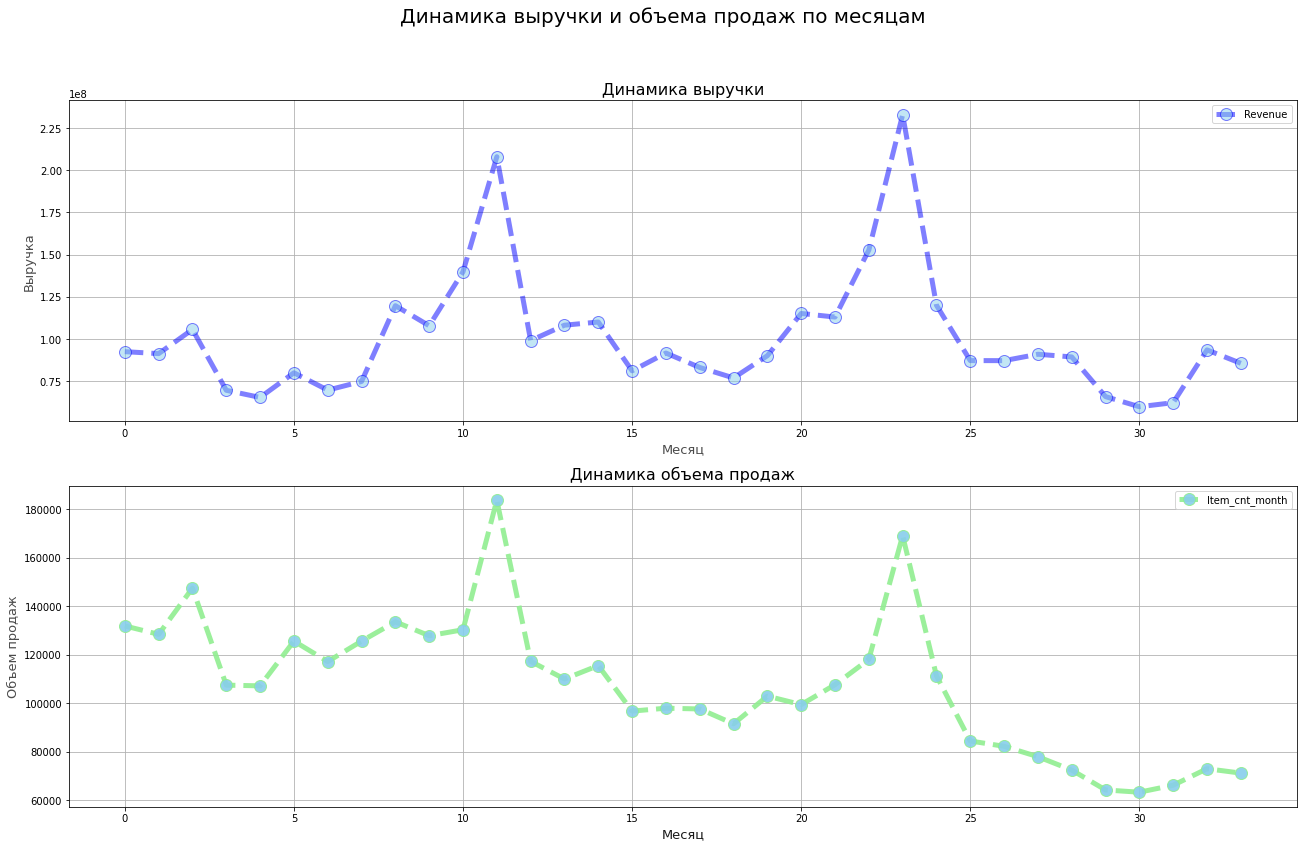

In [10]:
painter.plot_month_realation

        По первому графику можно увидеть, что выручка на начало и конец периода находится примерно на одном уровне, когда на втором графике заметен небольшой спад объема продаж к 2015 году. Отсюда можно предположить рост цены на товары, что вполне логично с течением времени, либо люди стали покупать более дорогие товары. 
        Также видим на обоих графиках похожие скачки роста продаж, но можно заметить, что скачки приходятся на декабрь каждого года, что также логично , так как продажи под новый тгод всегда растут.

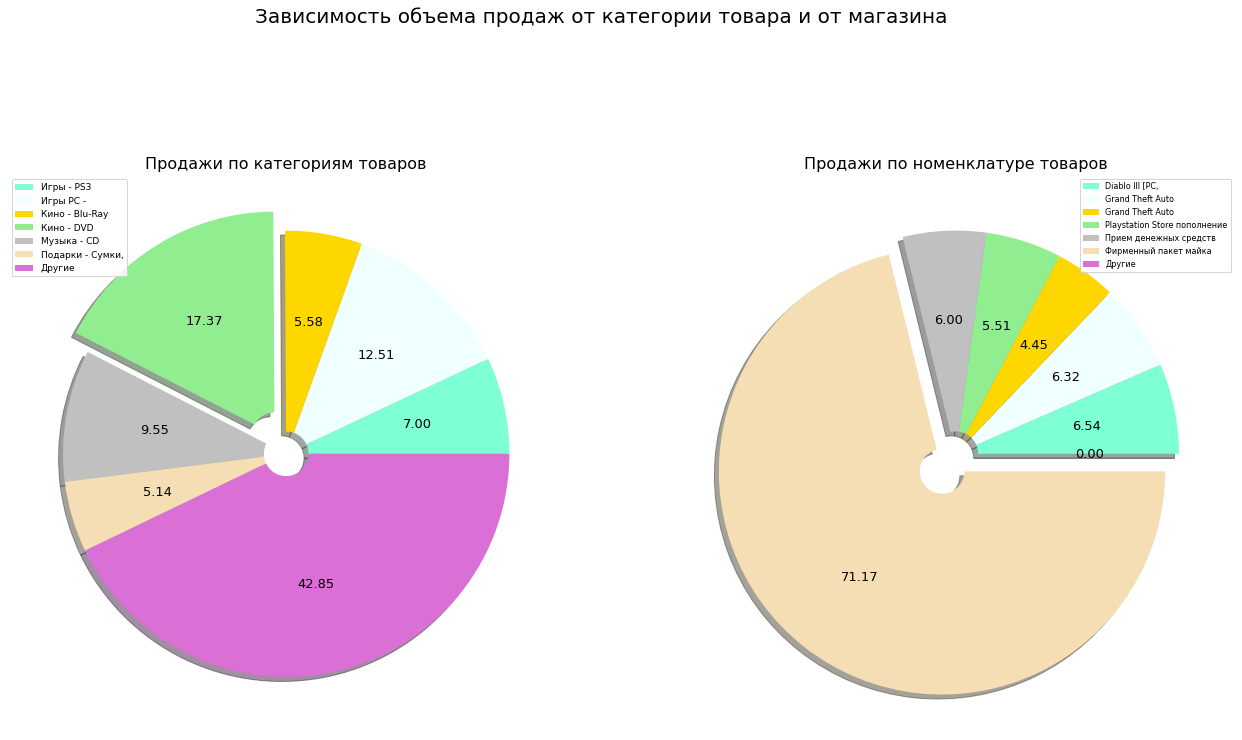

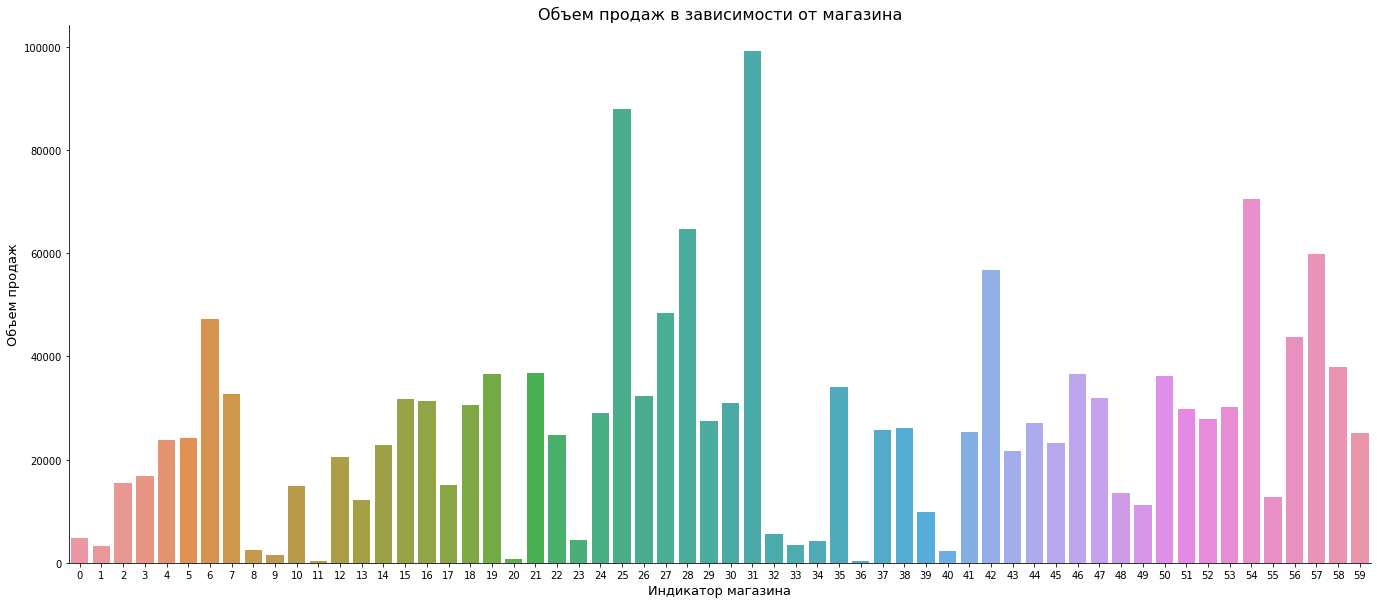

In [11]:
painter.plot_shop_category_relation

        Самой популярной категорией товаров являются DVD диски, а самым часто продаваемым товаром является пакет майка. Магазины с индикаторами 31 и 25 являются лидерами по числу продаж, но если посмотреть на город их расположения, то можно заметить, что оба магазина находятся в Москве, так что можно попробовать использовать признак города, в которм находится магазин для построения модели

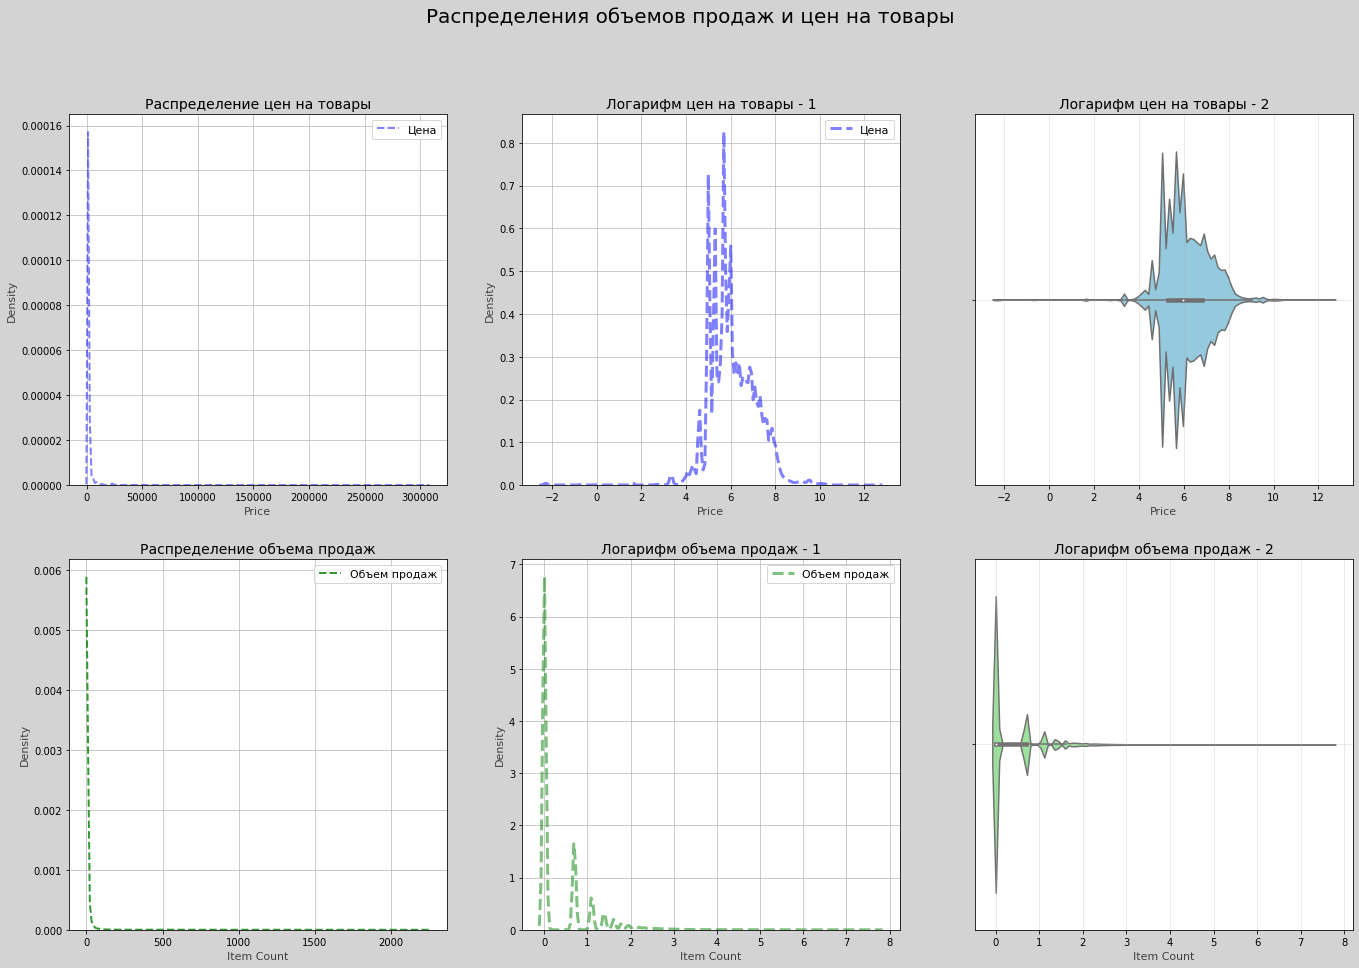

In [12]:
painter.plot_numeric_features_distribution

        Видим, что распределение цены и объема продаж не похоже на нормальное. Поэтому пробуем взять их логарифмы и получается немного лучше. Исходя из этого, можно попробовать использовать прологарифмированный признак цены товара для построения модели. Но это может быть полезным только при использовании линейных моделей, для деревьев решений это значения не имеет.

## 3. Обучение моделей
- Генерация новых признаков
- Обучение градиентного бустинга

In [13]:
## Реализуем классы для предобработки данных и обучения моделей

class Preprocessing:
    """ Класс для преобразования данных"""
    
    def __init__(self, X_train, X_test):
        self.X_train = X_train.copy()
        self.X_test = X_test.copy()
        
    ## метод для кодирования категориальных переменных с помощью LabelEncoder   
    def label_encoding(self, columns): 
        new_train = self.X_train.copy()
        new_test = self.X_test.copy()
        encoder = LabelEncoder()
        for column in columns:
            new_train[column] = encoder.fit_transform(new_train[column])
            new_test[column] = encoder.fit_transform(new_test[column])
        return new_train, new_test
    
    ## метод для стандартизации данных
    def scaller(self, train, test):  
        scaller = RobustScaler()
        return scaller.fit_transform(train), scaller.fit_transform(test)
        
        
class SplitData:
    """ Класс для разделения данных на обучение и тест"""
            
    def split_data(self, train):
        df = train.copy()
        last_block_num = sorted(train.date_block_num.unique())[-1]
        df_train = df[df.date_block_num < last_block_num]
        df_test = df[df.date_block_num == last_block_num]
        return df_train, df_test
    
    def split_X_y(self, train, test):
        X_train = train.drop(columns = 'item_cnt_day')
        y_train = train['item_cnt_day']
        if 'item_cnt_day' in test.columns:
            X_test = test.drop(columns = 'item_cnt_day')
            y_test = test['item_cnt_day']
            return X_train, X_test, y_train, y_test
        else:
            X_test = test
            return X_train, X_test, y_train
            
        
         

class ModelTrain:
    """ Класс для обучения модели"""
    
    def __init__(self, train, model, test=None, is_calculate_test=True, cat_columns=None, drop_columns=None, decomposition=None):
        self.train = train.copy()
        self.model = model
        self.is_calculate_test = is_calculate_test
        self.transformer = decomposition
        self.cat_columns = cat_columns or []
        self.drop_columns = drop_columns or []
        if test is not None:
            self.test = test.copy()
        else:
            self.test = None

    
    ## Кодируем категориальные переменные
    def encoding(self, X_train, X_test): 
        train = X_train.copy()
        test = X_test.copy()
        transformer = Preprocessing(train, test)
        train, test = transformer.label_encoding(self.cat_columns)
        train, test = transformer.scaller(train, test)
        
        return train, test
    
    ## Применяем методы понижения размерности
    def decomposition(self, X_train, X_test): 
        train = X_train.copy()
        test = X_test.copy()
        transformer = self.transformer
        train = transformer.fit_transform(train)
        test = transformer.transform(test)
        
        return train, test
    
    ## Удаляем лишние колонки
    def drop(self, X_train, X_test): 
        return X_train.drop(columns=self.drop_columns), X_test.drop(columns=self.drop_columns)
    
    
    ## Обучение модели и вывод результатов
    @property
    def fit(self):  
        
        splitter = SplitData()
        if self.test is not None:
            if 'item_cnt_day' in self.test.columns:

                X_train, X_test, y_train, y_test = splitter.split_X_y(self.train, self.test)
            else:
                X_train, X_test, y_train = splitter.split_X_y(self.train, self.test)
        else:
            train, test = splitter.split_data(self.train)
            X_train, X_test, y_train, y_test = splitter.split_X_y(train, test)
    
    
        X_train, X_test = self.drop(X_train, X_test)
        X_train, X_test = self.encoding(X_train, X_test)
        if self.transformer is not None:
            X_train, X_test = self.decomposition(X_train, X_test)
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.model.fit(X_train, y_train)
        
        if self.is_calculate_test:
            self.y_test = y_test
            r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test = self.calculate_metrics
            print('R2 на обучении: {}, R2 на тесте: {}'.format(r2_train, r2_test))
            print('MAE на обучении: {}, MAE на тесте: {}'.format(mae_train, mae_test))
            print('RMSE на обучении: {}, RMSE на тесте: {}'.format(rmse_train, rmse_test))
            
        else:
            r2_train, mae_train, rmse_train = self.calculate_metrics
            print('R2 на обучении: {}'.format(r2_train))
            print('MAE на обучении: {}'.format(mae_train))
            print('RMSE на обучении: {}'.format(rmse_train))
            
    def predict(self, X):
        return self.model.predict(X)
    
    
    ## атрибут для рассчета метрик
    @property
    def calculate_metrics(self): 
        
        y_pred_train = self.predict(self.X_train)
        
        r2_train = r2_score(self.y_train, y_pred_train)      
        mae_train = mae(self.y_train, y_pred_train)
        rmse_train = np.sqrt(mse(self.y_train, y_pred_train))
         
        if self.is_calculate_test:
        
            y_pred_test = self.predict(self.X_test)
            r2_test = r2_score(self.y_test, y_pred_test)
            mae_test = mae(self.y_test, y_pred_test)
            rmse_test = np.sqrt(mse(self.y_test, y_pred_test))
        
            return r2_train, r2_test, mae_train, mae_test, rmse_train, rmse_test
        
        else:
            return r2_train, mae_train, rmse_train

In [14]:
%%time
## Попробуем обучить LGBMRegressor
model = LGBMRegressor(random_state=42)
drop_columns = ['shop_name', 'item_name', 'item_category_name', 'date_block_num', 'year', 'min_date', 'max_date']
model_trainer = ModelTrain(data, model, drop_columns=drop_columns)
model_trainer.fit

R2 на обучении: 0.8017856900904062, R2 на тесте: 0.2783395493657108
MAE на обучении: 0.3709518348027339, MAE на тесте: 0.5489298800421051
RMSE на обучении: 3.7817303044444377, RMSE на тесте: 12.347833252259742
CPU times: user 12.7 s, sys: 556 ms, total: 13.3 s
Wall time: 7.39 s


Видим, что RMSE получилась достаточно большая. Дальше попробуем сгенерировать новые признаки

In [15]:
## Создадим класс для генерации новых признаков

## Сначала сгенерируем признак города исходя из названия магазина.
## Дальше мы будем создавать признаки для каждого магазина, продукта, города, категории продуктов.
## Сгенерируем продажи за последний месяц, за последние два месяца, за последние три месяца для каждого из выше перечисленных признаков.

class FeatureGenerator:
    """ Клас для создания новых признаков"""
    
    def __init__(self, train, test):
        self.train = train.copy()
        self.test = test.copy()
    
    ## Атрибут для генерации признака города 
    @property
    def generate_city(self):
        self.train['city'] = self.train.shop_name.apply(lambda x: x.split(' ')[0])
        self.test['city'] = self.test.shop_name.apply(lambda x: x.split(' ')[0])
      
    ## Атрибут для объединения всего имеющегося текста 
    @property
    def generate_text(self):
        self.train['text'] = self.train['shop_name'] + ' ' + self.train['item_category_name'] + ' ' + self.train['item_name']
        self.test['text'] = self.test['shop_name'] + ' ' + self.test['item_category_name'] + ' ' + self.test['item_name']
        
    ## Возвращаем новый датафрейм 
    @property
    def get_data(self):
        return self.train, self.test
    
    ## Вспомогательные функции 
    ## last_rate, last_rate_2, last_rate_3 - для генерации объема продаж за последний месяц, 2 месяца, 3 месяца соответственно
    def last_rate(self, arg, date_block_num, item_cnt_day):
        if self.use_dict[arg]['last_sum'] == 1:
            self.use_dict[arg]['last_sum'] = item_cnt_day
            return None
        elif date_block_num - self.use_dict[arg]['date'] == 1:
            result = self.use_dict[arg]['last_sum']
            self.use_dict[arg]['last_sum'] = item_cnt_day
            self.use_dict[arg]['date'] = date_block_num
            return result
        else:
            return None
        
    def last_rate_2(self, arg, date_block_num, item_cnt_day):
        if self.use_dict_2[arg]['last_sum_1'] == 1:
            self.use_dict_2[arg]['last_sum_1'] = item_cnt_day
            return None
        elif self.use_dict_2[arg]['last_sum_2'] == 1:
            self.use_dict_2[arg]['last_sum_2'] = item_cnt_day
            return None
        elif (date_block_num - self.use_dict_2[arg]['date'] == 1) | (date_block_num - self.use_dict_2[arg]['date'] == 2):
            result = (self.use_dict_2[arg]['last_sum_1'] + self.use_dict_2[arg]['last_sum_2'])/2
            self.use_dict_2[arg]['last_sum_1'] = self.use_dict_2[arg]['last_sum_2']
            self.use_dict_2[arg]['last_sum_2'] = item_cnt_day
            self.use_dict_2[arg]['date'] = date_block_num
            return result
        else:
            return None
    
    def last_rate_3(self,arg, date_block_num, item_cnt_day):
        if self.use_dict_3[arg]['last_sum_1'] == 1:
            self.use_dict_3[arg]['last_sum_1'] = item_cnt_day
            return None
        elif self.use_dict_3[arg]['last_sum_2'] == 1:
            self.use_dict_3[arg]['last_sum_2'] = item_cnt_day
            return None
        elif self.use_dict_3[arg]['last_sum_3'] == 1:
            self.use_dict_3[arg]['last_sum_3'] = item_cnt_day
            return None    
        elif ((date_block_num - self.use_dict_3[arg]['date'] == 1) | (date_block_num - self.use_dict_3[arg]['date'] == 2) |
            (date_block_num - self.use_dict_3[arg]['date'] == 3)):
            
                result = (self.use_dict_3[arg]['last_sum_1'] + self.use_dict_3[arg]['last_sum_2'] + self.use_dict_3[arg]['last_sum_3'])/3
                self.use_dict_3[arg]['last_sum_1'] = self.use_dict_3[arg]['last_sum_2']
                self.use_dict_3[arg]['last_sum_2'] = self.use_dict_3[arg]['last_sum_3']
                self.use_dict_3[arg]['last_sum_3'] = item_cnt_day
                self.use_dict_3[arg]['date'] = date_block_num
                return result
        else:
            return None
        
    ## Метод для генерации объемов продаж
    def genarate_last_rate(self, feature_name, new_feature_name):
        
        self.use_dict = {x: {'date': 0, 'last_sum': 1} for x in sorted(self.train[feature_name].unique())}
        self.use_dict_2 = {x: {'date': 0, 'last_sum_1': 1, 'last_sum_2': 1} for x in sorted(self.train[feature_name].unique())}
        self.use_dict_3 = {x: {'date': 0, 'last_sum_1': 1, 'last_sum_2': 1, 'last_sum_3': 1} for x in sorted(self.train[feature_name].unique())}
        
        last_rate_name_1 = new_feature_name +'_1'
        last_rate_name_2 = new_feature_name +'_2'
        last_rate_name_3 = new_feature_name +'_3'
        
        
        feature_group = self.train.groupby([feature_name, 'date_block_num'])['item_cnt_day'].sum().reset_index()
        last_date_block_nums = sorted(self.train.date_block_num.unique())[-3:]
        
        group_test_1 = feature_group[feature_group.date_block_num.isin(last_date_block_nums[-1:])]
        group_test_1 = group_test_1.groupby(feature_name)['item_cnt_day'].mean().reset_index()
        group_test_1 = group_test_1.rename(columns={'item_cnt_day': last_rate_name_1})
        group_test_2 = feature_group[feature_group.date_block_num.isin(last_date_block_nums[-2:])]
        group_test_2 = group_test_2.groupby(feature_name)['item_cnt_day'].mean().reset_index()
        group_test_2 = group_test_2.rename(columns={'item_cnt_day': last_rate_name_2})
        group_test_3 = feature_group[feature_group.date_block_num.isin(last_date_block_nums[-3:])]
        group_test_3 = group_test_3.groupby(feature_name)['item_cnt_day'].mean().reset_index()
        group_test_3 = group_test_3.rename(columns={'item_cnt_day': last_rate_name_3})
        
        feature_group[last_rate_name_1] = feature_group[[feature_name, 'date_block_num', 'item_cnt_day']].apply(lambda x: self.last_rate(x[0], x[1], x[2]), axis=1)
        feature_group[last_rate_name_1].fillna(feature_group[last_rate_name_1].median(), inplace=True)
        feature_group[last_rate_name_2] = feature_group[[feature_name, 'date_block_num', 'item_cnt_day']].apply(lambda x: self.last_rate_2(x[0], x[1], x[2]), axis=1)
        feature_group[last_rate_name_2].fillna(feature_group[last_rate_name_2].median(), inplace=True)
        feature_group[last_rate_name_3] = feature_group[[feature_name, 'date_block_num', 'item_cnt_day']].apply(lambda x: self.last_rate_3(x[0], x[1], x[2]), axis=1)
        feature_group[last_rate_name_3].fillna(feature_group[last_rate_name_3].median(), inplace=True)
        
        feature_group.drop(columns='item_cnt_day', inplace=True)
        self.train = pd.merge(self.train, feature_group, on=[feature_name, 'date_block_num'])
        group_test = pd.merge(pd.merge(group_test_1, group_test_2, on=feature_name), group_test_3, on=feature_name)
        self.test = pd.merge(self.test, group_test, on=feature_name, how='left').fillna(0)
        
        self.train = self.train.sort_values(by='date_block_num').reset_index(drop=True)
        self.test = self.test.sort_values(by='date_block_num').reset_index(drop=True)

In [16]:
## Выполним трансформацию данных - сгенерируем новые признаки
df_train, df_test = SplitData().split_data(data)
df_train, df_test = df_train.sort_values(by='date_block_num').reset_index(drop=True), df_test.sort_values(by='date_block_num').reset_index(drop=True)
feature_generator = FeatureGenerator(df_train, df_test.drop(columns='item_cnt_day'))
y_test = df_test[['date_block_num', 'shop_id', 'item_id', 'item_cnt_day']]
feature_generator.generate_city
feature_generator.generate_text
feature_generator.genarate_last_rate('shop_id', 'shop_last_rate')
feature_generator.genarate_last_rate('item_id', 'item_last_rate')
feature_generator.genarate_last_rate('item_category_id', 'category_last_rate')
feature_generator.genarate_last_rate('city', 'city_last_rate')
df_train, df_test = feature_generator.get_data
df_test = pd.merge(df_test, y_test, on=['date_block_num', 'shop_id', 'item_id'])

In [17]:
%%time
## Снова попробуем обучить LGBMRegressor
model = LGBMRegressor(random_state=42)

drop_columns = ['shop_name', 'item_name', 'item_category_name', 'year', 'min_date', 'max_date', 'text']
cat_columns = ['city']
model_trainer = ModelTrain(train=df_train, model=model, test=df_test, cat_columns=cat_columns, drop_columns=drop_columns)
model_trainer.fit

R2 на обучении: 0.845214488541452, R2 на тесте: 0.2609252736166493
MAE на обучении: 0.3506791788306688, MAE на тесте: 0.5256949850967747
RMSE на обучении: 3.341859634527713, RMSE на тесте: 12.495926990060855
CPU times: user 20.3 s, sys: 1.1 s, total: 21.4 s
Wall time: 13.1 s


        Качество не поменяось. Генерация данных признаков привела только к уменьшению ошибки на тесте. Но ошибка RMSE по-прежнему слишком большая. Теперь попробуем по-другому преобразовать данные

## 4. Новое представление данных
- Представление данных в виде сводной таблицы
- Обучение LightGBM
- Использование рекурентной нейросети LSTM

In [18]:
## Создадим функции для преобразования данных и обучения модели

## transform_pivot_table - преобразуем данные в сводную таблицу, где каждая колонка будет отвечать за определенный месяц, 
## а каждая строка за определенный товар в определенном магазине

## transform_test_pivot - преобразуем тестовый набор к тому же формату

## split_pivot - разделим данные на тест и обучение таким образом, что колонка с последним месяцем будет являться целевой переменной, соответсвенно
## для теста удалим первую колонку, чтобы уровнять количество колонок

## train_pivot - обучение модели и отображение результатов

def transform_pivot_table(dataframe):
    df = dataframe.copy()
    new_df = pd.pivot_table(df, index=['shop_id', 'item_id'], columns='date_block_num', values='item_cnt_day', aggfunc='sum').reset_index()
    new_df.fillna(0, inplace=True)
    return new_df

def transform_test_pivot(dataframe):
    df = dataframe.copy()
    new_df = pd.merge(df_test_sales, pivot, on=['shop_id', 'item_id'], how='left').fillna(0)
    new_df = new_df.sort_values(by='ID').reset_index(drop=True)
    new_df_1 = new_df.drop(columns=[0, 'ID'])
    new_df_2 = new_df.drop(columns=['ID'])

    return new_df_1, new_df_2

def split_pivot(dataframe, last_column=33, test=True):
    df = dataframe.copy()
    if test:
        try:
            df_train = df.drop(columns=last_column)
            df_test = df.drop(columns=0)
            X_train = df_train.drop(columns=last_column-1)
            y_train = df_train[last_column-1]
            X_test = df_test.drop(columns=last_column)
            y_test = df_test[last_column]
        except KeyError:
            df_train = df.drop(columns=str(last_column))
            df_test = df.drop(columns=str(0))
            X_train = df_train.drop(columns=str(last_column-1))
            y_train = df_train[str(last_column-1)]
            X_test = df_test.drop(columns=str(last_column))
            y_test = df_test[str(last_column)]
        return X_train, X_test, y_train, y_test
    else:
        try:
            X_train = df.drop(columns=[last_column])
            y_train = df[last_column]
        except KeyError:
            X_train = df.drop(columns=[str(last_column)])
            y_train = df[str(last_column)]
        return X_train, y_train

def train_pivot(model, X_train, X_test, y_train, y_test=None):
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
        
    r2_train = r2_score(y_train, y_pred_train)      
    mae_train = mae(y_train, y_pred_train)
    rmse_train = np.sqrt(mse(y_train, y_pred_train))
    
    y_pred_test = model.predict(X_test)
                         
    if y_test is None:
        
        print('R2 на обучении: {}'.format(r2_train))
        print('MAE на обучении: {}'.format(mae_train))
        print('RMSE на обучении: {}'.format(rmse_train))
                         
    else:
        
        r2_test = r2_score(y_test, y_pred_test)
        mae_test = mae(y_test, y_pred_test)
        rmse_test = np.sqrt(mse(y_test, y_pred_test))
        print('R2 на обучении: {}, R2 на тесте: {}'.format(r2_train, r2_test))
        print('MAE на обучении: {}, MAE на тесте: {}'.format(mae_train, mae_test))
        print('RMSE на обучении: {}, RMSE на тесте: {}'.format(rmse_train, rmse_test))
                  
    return y_pred_test
                         
def drop_pivot_columns(dataframe, columns=[]):
    df = dataframe.copy()
    df = df.drop(columns=columns)
    return df

def merge_with_test(dataframe):
    df = dataframe.copy()
    new_df = df[(df.shop_id.isin(df_test_sales.shop_id)) & (df.item_id.isin(df_test_sales.item_id))]
    return new_df.reset_index(drop=True)


In [19]:
## Создадим новые датасеты и сохраним на диске
drop_columns=['shop_id', 'item_id']
pivot = transform_pivot_table(df_sales)
pivot_test_1, pivot_test_2  = transform_test_pivot(pivot)
pivot_test_1 = drop_pivot_columns(pivot_test_1, drop_columns)
pivot_test_2 = drop_pivot_columns(pivot_test_2, drop_columns)
pivot = merge_with_test(pivot)
pivot = drop_pivot_columns(pivot, drop_columns)
pivot.to_csv('df_FeatueSales.csv', index=False)
pivot_test_1.to_csv('df_FeatureSales_test_1.csv', index=False)
pivot_test_2.to_csv('df_FeatureSales_test_2.csv', index=False)

In [20]:
pivot = pd.read_csv('../input/feature-sales/df_FeatueSales.csv')
#pivot_test_1 = pd.read_csv('../input/feature-sales-dataset/df_FeatureSales_test_1.csv')
pivot_test_2 = pd.read_csv('../input/feature-sales/df_FeatureSales_test_2.csv')

In [21]:
%%time
## Cнова обучим модель
X_train, X_test, y_train, y_test = split_pivot(pivot)
lgb = LGBMRegressor(random_state=42, learning_rate=0.03, num_leaves=20, n_estimators=100)
pred = train_pivot(lgb, X_train, X_test, y_train, y_test)

R2 на обучении: 0.34266998202431, R2 на тесте: -0.08114727862371174
MAE на обучении: 0.19590603830182104, MAE на тесте: 0.21616311465575835
RMSE на обучении: 1.4769169250394205, RMSE на тесте: 1.3165256696159868
CPU times: user 2.89 s, sys: 200 ms, total: 3.09 s
Wall time: 1.74 s


      Теперь результаты гораздо лучше, за счет того, что модель использует данные об истории продаж по каждому товару в каждом магазине.

In [22]:
# Теперь обучим модель на всех данных и получим предсказание для теста
%time
X_test = pivot_test_1
X_train, y_train = split_pivot(pivot, test=False)
pred = train_pivot(lgb, X_train, X_test, y_train)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 12.2 µs
R2 на обучении: 0.17391277292723206
MAE на обучении: 0.2198260432554793
RMSE на обучении: 1.1508000053628376


In [23]:
## Отправим результаты
df_sample = pd.read_csv('../input/competitive-data-science-predict-future-sales/sample_submission.csv')
df_sample['item_cnt_month'] = pred
df_sample.to_csv('submission_3.csv', index=False)
df_sample.head()

,ID,item_cnt_month
0,0,0.482344
1,1,0.120924
2,2,0.796106
3,3,0.155103
4,4,0.120924


        Следующим шагом попробуем построить рекурентную нейросеть LSTM и обучить ее на нашем датасете

In [24]:
## Создадим класс нейросети LSTM, которая будет состоять из одного слоя, скрытую размерность возьмем равной 64
## Дальше возьмем выход последней ячейки сети и применим к нему полносвязный слой с 1 значением на выходе, 
## которое и будет предсказанием для количества продаж в следующем месяце
class LSTMNet(nn.Module):
    """ Класс определяющий нейросеть LSTM """
    
    def __init__(self, num_layers=1, hidden_size=64):
        super(LSTMNet, self).__init__()
        
        self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.dense = nn.Linear(hidden_size, 1)
        self.flatten = nn.Flatten()
        
    def forward(self, x):
        
        x, h = self.lstm(x)
        x = x[:,-1,:]
        x = x.view(x.shape[0], 1, x.shape[1])
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.dense(x)
        
        return x, h
    

In [25]:
## Создадим датасет, чтобы итерироваться по нашим данным
class SalesDataset(Dataset):
    """ Класс для создания датасета SalesDataset"""
    
    def __init__(self, pivot, marker='train'):
        self.data = pivot.copy()
        self.marker = marker
        
        if marker == 'train':
            self.data, _ = self.split_data
        elif marker == 'val':
            _, self.data = self.split_data
        elif marker == 'test':
            self.data = self.data
        else:
            raise NameError
    
    ## разбиваем данные на валлидацию и обучение
    @property   
    def split_data(self):
        last_column = sorted(self.data.columns)[-1]
        first_column = sorted(self.data.columns)[1]
        df_train = self.data.drop(columns=last_column)
        df_test = self.data.drop(columns=first_column)
        
        return df_train, df_test
    
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        
        x = torch.from_numpy(self.data.iloc[idx].values).float()
        if self.marker != 'test':
            y = x[-1]
            x = x[:-1]
            x = x.view(len(x), 1)
            return x, y
        else:
            x = x[:-1]
            x = x.view(len(x), 1)
            return x


In [26]:
## Создадим наши датасеты и затем создадим соответствующие даталоадеры
## Batch_size для обучения возьмем равным 2, чтобы модель могла посмотерть на каждую последовательность в отдельности.
trainset = SalesDataset(pivot, marker='train')
valset = SalesDataset(pivot, marker='val')
testset = SalesDataset(pivot_test_2, marker='test')

train_loader = DataLoader(trainset, batch_size=2, shuffle=True)
val_loader = DataLoader(valset, batch_size=512, shuffle=False)
test_loader = DataLoader(testset, batch_size=512, shuffle=False)

In [27]:
## Создадим функции для обучения и валлидации модели, также функцию для предсказания результатов на тесте

## train_epoch - функция для обучения одной эпохи
## train_net - функция для обучения нескольких эпох, а также отображения промежуточных результатов
## evaluate_epoch - функция для рассчета ошибки на валлидации для каждой эпохи
## predict - расчет результата на тесте

def train_epoch(model, data_loader, optimizer, criterion, device):
    train_loss = []
    train_processed = 0
    preds, answers = [], []
    for inputs, labels in tqdm(data_loader):
        
        model.train()
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        output, h = model(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        train_loss.append(np.sqrt(loss.item()))
        train_processed += 1
        
        if train_processed % 10000 == 0:
            print('Trian Loss: {}'.format(np.mean(train_loss)))
        
        model.eval()
        with torch.no_grad():
            output = output.to('cpu').view(output.shape[0]).numpy()
            output = [out for out in output]
            labels = labels.to('cpu').view(labels.shape[0]).numpy()
            labels = [label for label in labels]
            
            preds.extend(output)
            answers.extend(labels)
        
    preds = torch.FloatTensor(preds)
    answers = torch.FloatTensor(answers)
    with torch.no_grad():
        loss = criterion(preds, answers)
    
    return np.sqrt(loss.item())

def train_net(model, train_loader, val_loader, device, num_epochs, learning_rate):
    
    val_loss_history = []
    train_loss_history = []
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    for epoch in range(num_epochs):

        train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
        val_loss = evaluate_epoch(model, val_loader, device, criterion)
        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)
        clear_output()
        
        if epoch == 0:
            print('Iteration: {}'.format(epoch))
            print('Train_loss: {}'.format(train_loss_history[epoch]))
            print('Val_loss: {}'.format(val_loss_history[epoch]))
        elif epoch == 1:
            print('Iteration: {}'.format(epoch))
            print('Train_loss: {}, {}'.format(train_loss_history[epoch-1], train_loss_history[epoch]))
            print('Val_loss: {}, {}'.format(val_loss_history[epoch-1], val_loss_history[epoch]))   
        else:
            print('Iteration: {}'.format(epoch))
            print('Train_loss: {}, {}, {}'.format(train_loss_history[epoch-2], train_loss_history[epoch-1], train_loss_history[epoch]))
            print('Val_loss: {}, {}, {}'.format(val_loss_history[epoch-2], val_loss_history[epoch-1], val_loss_history[epoch]))


def evaluate_epoch(model, data_loader, device, criterion):
    model.eval()
    preds = []
    answers = []
    
    for inputs, labels in tqdm(data_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        with torch.no_grad():
            output, h = model(inputs)
        
        output = output.to('cpu').view(output.shape[0]).numpy()
        output = [out for out in output]
        labels = labels.to('cpu').view(labels.shape[0]).numpy()
        labels = [label for label in labels]
        
        preds.extend(output)
        answers.extend(labels)
    
    preds = torch.FloatTensor(preds)
    answers = torch.FloatTensor(answers)
    with torch.no_grad():
        loss = criterion(preds, answers)
        
    return np.sqrt(loss.item())


def predict(model, data_loader, device):
    model.eval()
    preds = []
    
    for inputs in tqdm(data_loader):
        inputs = inputs.to(device)

        with torch.no_grad():
            output, h = model(inputs)
            
        output = output.to('cpu').view(output.shape[0]).numpy()
        output = [out for out in output]
        
        preds.extend(output)
    
        
    return np.array(preds)

In [ ]:
## Пробуем обучить модель
model = LSTMNet()
model.to('cuda')
train_net(model, train_loader, val_loader, device='cuda', num_epochs=20, learning_rate=1e-4)

In [ ]:
## Снова отправляем результат
df_sample = pd.read_csv('../input/competitive-data-science-predict-future-sales/sample_submission.csv')
result = predict(model, test_loader, device='cuda')
df_sample['item_cnt_month'] = result
df_sample.to_csv('submission_4.csv', index=False)
df_sample.head()

In [ ]:
## Попробуем отправить линейную комбинацию результатов
df_sample = pd.read_csv('../input/competitive-data-science-predict-future-sales/sample_submission.csv')
mean_result = (0.7*pred + 0.3*result)
df_sample['item_cnt_month'] = mean_result
df_sample.to_csv('submission_5.csv', index=False)
df_sample.head()

## Итоговые результаты: 
1. Лучшие результаты достигнуты с использованием данных представленных в виде сводной таблицы (каждый столбец отображает количество продаж в определенном месяце по каждому магазину с разбивкой по товарам)
2. Модель LGBMRegressorrandom_state=42, learning_rate=0.03, num_leaves=20, n_estimators=100) показала лучшие результаты - RMSE: 1.02
3. Использование нейросети LSTM привело чуть к более низким результатам - RMSE: 1.18. Также обучение LSTM заняло гораздо больше времени